# Revenue Leakage Detection in Billing Data

![Anomaly Detection](https://img.shields.io/badge/ML-Revenue%20Leakage%20Detection-blue)
![Python](https://img.shields.io/badge/Python-3.11-green)
![Jupyter](https://img.shields.io/badge/Jupyter-Notebook-orange)

### 🎯 End-to-End Machine Learning flow for Revenue Leakage Detection
This notebook demonstrates a machine learning flow for detecting revenue leakage in billing data using anomaly detection techniques. The workflow follows industry best practices for unsupervised learning in financial systems.

**Machine Learning Flow:**
1. **Environment Setup & Library Import**  
   - Configure environment, install dependencies, and import essential libraries.

2. **Data Ingestion & Integration**  
   - Load data from multiple sources (databases, APIs, CSVs) and merge into a unified dataset.

3. **Exploratory Data Analysis (EDA)**  
   - Understand data distributions, relationships, and key patterns through visualization and statistics.

4. **Data Quality Assessment & Ground Truth Analysis**  
   - Identify missing values, duplicates, inconsistencies, and validate against source-of-truth data.

5. **Feature Engineering**  
   - Create new features, encode categorical variables, and derive domain-specific insights.

6. **Data Preprocessing & Transformation**  
   - Normalize, scale, encode, and prepare the final dataset for model input.

7. **Model Training**  
   - Train selected algorithms using the prepared data, tuning hyperparameters for optimal performance.

8. **Model Evaluation & Algorithm Selection**  
   - Compare multiple models using defined metrics (accuracy, F1, AUC, etc.) to select the best-performing one.

9. **Results Analysis & Business Insights**  
   - Interpret results, extract actionable insights, and translate model outcomes into business impact.


### **Business Context**
Revenue leakage occurs when companies fail to capture revenue they're entitled to due to:
- **Billing System Errors** - Processing failures and calculation mistakes
- **Incorrect Pricing or Tax Calculations** - Wrong rates or computation errors
- **Process Inefficiencies** - Manual errors and workflow gaps
- **Data Quality Issues** - Inconsistent or corrupted billing data
- **Fraudulent Activities** - Unauthorized discounts or manipulated transactions

**Financial Impact**: Studies show revenue leakage can cost companies 1-5% of their total revenue annually, translating to millions in lost profits for large enterprises.

### **Machine Learning Approach**
Our solution leverages multiple unsupervised learning algorithms for anomaly detection, **Algorithms Implemented:**
- **Isolation Forest** - Tree-based anomaly detection optimized for high-dimensional data
- **DBSCAN** - Density-based clustering to identify outliers in feature space
- **Smart Hybrid Ensemble** - Intelligent combination of multiple algorithms with performance-based weighting

## 1. Environment Setup & Library Import

In [1]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import time
import os
from datetime import datetime
import random
import warnings
import sklearn
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Core Algorithms (only what's actually used)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

print("✅ All libraries imported successfully!")
print(f"📊 Using pandas version: {pd.__version__}")
print(f"🧮 Using numpy version: {np.__version__}")
print(f"🎨 Using matplotlib version: {plt.matplotlib.__version__}")
print(f"🤖 Using scikit-learn version: {sklearn.__version__}")

✅ All libraries imported successfully!
📊 Using pandas version: 2.3.2
🧮 Using numpy version: 2.3.3
🎨 Using matplotlib version: 3.10.6
🤖 Using scikit-learn version: 1.7.2


## 2. Data Ingestion & Integration

Load and combine multiple billing datasets to create a dataset for anomaly detection. Our integrated dataset includes:
- **Primary Dataset**: `data/billing_data.csv` (10,000 records) - Main transaction data
- **Anomaly Dataset**: `data/billing_anomaly_data.csv` (10 records) - Known anomaly examples for validation
- **Combined Total**: 10,010 records representing $77.1M in revenue

#### **Core Data Schema**
- **invoice_id**: Unique identifier for each invoice
- **customer_id**: Customer identifier following business patterns
- **country**: Geographic distribution across major markets (US, UK, DE, FR, CA, AU, JP, SG, IN)
- **net_value**: Invoice amounts in local currency
- **tax_rate**: Country-specific tax rates (7%-20%)
- **currency**: Local currency codes (USD, GBP, EUR, CAD, AUD, JPY, SGD, INR)
- **total_amount**: Net value + tax amount
- **invoice_date**

#### **Ground Truth Anomaly Types**
1. **Zero/Negative amounts** - Invalid transaction values
2. **Incorrect tax calculations** - Mismatched tax rates and amounts
3. **Extreme outliers** - Unusually high transaction amounts
4. **Invalid currency/country combinations** - Geographic inconsistencies

In [2]:
def load_csv_data(file_name):
    try:
        file_size = os.path.getsize(file_name) / (1024**2)  # Size in MB
        print(f"\n📂 Dataset: {file_name}")
        print(f"📏 File size: {file_size:.2f} MB")
        
        start_time = time.time()
        
        df = pd.read_csv(
            file_name,
            dtype={
                'quantity': 'int32',
                'unit_price': 'float32', 
                'tax_rate': 'float32'
            },
            engine='c'
        )
            
        load_time = time.time() - start_time
        print(f"✅ Dataset loaded in {load_time:.2f} seconds")
        print(f"📊 Shape: {df.shape}")
        
        return df
        
    except FileNotFoundError:
        print(f"❌ Error: {file_name} not found!")
        print("📂 Please ensure the file is in the same directory as this notebook")
        return None
    except Exception as e:
        print(f"❌ Error loading {file_name}: {str(e)}")
        return None

def load_and_prepare_billing_data(main_file='data/billing_data.csv', anomaly_file='data/billing_anomaly_data.csv'):
    """
    Load and combine billing data from multiple sources for anomaly detection
    """
    # Load datasets with error handling
    main_df = load_csv_data(main_file)
    anomaly_df = load_csv_data(anomaly_file)
    
    # Mark source for tracking
    main_df['source'] = 'main'
    anomaly_df['source'] = 'billing_anomaly_data'
            
    # Combine datasets 
    print(f"\n🔗 Combining datasets...")
    start_time = time.time()
    df = pd.concat([main_df, anomaly_df], ignore_index=True)
    combine_time = time.time() - start_time
    
    print(f"✅ Datasets combined in {combine_time:.3f} seconds")
    print(f"📊 Combined shape: {df.shape}")
    
    # Get indices of known anomalies
    known_anomaly_indices = df[df['source'] == 'billing_anomaly_data'].index.tolist()
    print(f"🚨 Known anomalies from billing_anomaly_data.csv: {len(known_anomaly_indices)} ({len(known_anomaly_indices)/len(df)*100:.1f}%)")

    # Clean up source column
    df = df.drop('source', axis=1)
    
    print(f"\n📋 Available columns ({len(df.columns)}): {list(df.columns)}")
    
    return df, known_anomaly_indices

def clean_data(df):
    # Data cleaning and validation
    print(f"\n🧹 Cleaning and validating combined data...")
    clean_start = time.time()
    
    # Remove any records with missing critical fields
    critical_fields = ['quantity', 'unit_price', 'total_amount']
    initial_count = len(df)
    df = df.dropna(subset=critical_fields)
    removed_count = initial_count - len(df)
    
    if removed_count > 0:
        print(f"Removed {removed_count} records with missing critical data")
    
    clean_time = time.time() - clean_start
    print(f"🧹 Cleaning completed in {clean_time:.2f} seconds")
    
    return df

In [3]:
# Load the combined billing datasets
billing_data, known_anomalies = load_and_prepare_billing_data(
    main_file='data/billing_data.csv',
    anomaly_file='data/billing_anomaly_data.csv'
)

# Clean the data
billing_data = clean_data(billing_data)

# Display basic info about data

# Show dataset composition
print(f"\n📈 Dataset Composition:")
status_counts = billing_data['invoice_status'].value_counts()
for status, count in status_counts.items():
    print(f"   • {status}: {count:,} ({count/len(billing_data)*100:.1f}%)")

print(f"Total records: {len(billing_data):,}")
print(f"Total revenue: ${billing_data['total_amount'].sum():,.2f}")
    
print("\nSample of generated billing data:")
display(billing_data.head(10))

print("\nBasic statistics:")
display(billing_data.describe())

# Display basic information

print(f"\n📊 Final combined dataset for anomaly detection:")
print(f"   Records: {len(billing_data):,}")
print(f"   Features: {len(billing_data.columns)}")
print(f"   Known anomalies: {len(known_anomalies)} ({len(known_anomalies)/len(billing_data)*100:.1f}%)")

stats_columns = ['quantity', 'unit_price', 'total_amount', 'tax_rate', 'net_value']
available_stats_cols = [col for col in stats_columns if col in billing_data.columns]

if available_stats_cols:
    print(f"\n📊 Combined Dataset Overview:")
    display(billing_data[available_stats_cols].describe())

print(f"\n📋 Sample of combined dataset:")
display(billing_data.head(10))



📂 Dataset: data/billing_data.csv
📏 File size: 1.03 MB
✅ Dataset loaded in 0.03 seconds
📊 Shape: (10000, 14)

📂 Dataset: data/billing_anomaly_data.csv
📏 File size: 0.00 MB
✅ Dataset loaded in 0.00 seconds
📊 Shape: (10, 14)

🔗 Combining datasets...
✅ Datasets combined in 0.000 seconds
📊 Combined shape: (10010, 15)
🚨 Known anomalies from billing_anomaly_data.csv: 10 (0.1%)

📋 Available columns (14): ['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']

🧹 Cleaning and validating combined data...
🧹 Cleaning completed in 0.00 seconds

📈 Dataset Composition:
   • Paid: 7,822 (78.1%)
   • Pending: 1,168 (11.7%)
   • Disputed: 618 (6.2%)
   • Cancelled: 402 (4.0%)
Total records: 10,010
Total revenue: $77,149,537.94

Sample of generated billing data:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.209961,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.000000,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.049988,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.239990,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.939941,2195.88,0.08,175.67,2371.55,Paid
5,INV-2025-000006,CUST-7912-IND,US,USD,2025-08-17,CAM-4K,Camera,5,2852.139893,14260.70,0.08,1140.86,15401.56,Paid
6,INV-2024-000007,CUST-1488-IND,US,USD,2024-06-07,GPU-RDNA,GPU,13,1435.930054,18667.09,0.08,1493.37,20160.46,Pending
7,INV-2025-000008,CUST-4582-IND,IN,INR,2025-05-08,SSD-1TB,SSD,31,254.520004,7890.12,0.18,1420.22,9310.34,Disputed
8,INV-2024-000009,CUST-9279-ENT,CA,CAD,2024-11-24,SWT-FIT,Smartwatch,6,157.899994,947.40,0.13,123.16,1070.56,Paid
9,INV-2025-000010,CUST-1434-ENT,AU,AUD,2025-09-05,TAB-MINI,Tablet,15,650.599976,9759.00,0.10,975.90,10734.90,Paid



Basic statistics:


,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount
count,10010.000000,10010.000000,10010.00000,10010.000000,10010.000000,10010.000000
mean,12.574525,818.439758,6754.37524,0.141524,953.118860,7707.246547
std,58.941412,5027.869141,5676.81437,0.051445,918.651955,6493.115269
min,1.000000,-100.000000,-4000.00000,0.080000,-800.000000,-4800.000000
25%,5.000000,301.775009,2397.19250,0.080000,300.852500,2731.102500
50%,9.000000,569.119995,5107.05000,0.130000,655.065000,5805.725000
75%,15.000000,1095.430054,9572.99000,0.190000,1298.715000,10955.760000
max,5000.000000,500000.000000,50000.00000,0.500000,10000.000000,60000.000000



📊 Final combined dataset for anomaly detection:
   Records: 10,010
   Features: 14
   Known anomalies: 10 (0.1%)

📊 Combined Dataset Overview:


,quantity,unit_price,total_amount,tax_rate,net_value
count,10010.000000,10010.000000,10010.000000,10010.000000,10010.00000
mean,12.574525,818.439758,7707.246547,0.141524,6754.37524
std,58.941412,5027.869141,6493.115269,0.051445,5676.81437
min,1.000000,-100.000000,-4800.000000,0.080000,-4000.00000
25%,5.000000,301.775009,2731.102500,0.080000,2397.19250
50%,9.000000,569.119995,5805.725000,0.130000,5107.05000
75%,15.000000,1095.430054,10955.760000,0.190000,9572.99000
max,5000.000000,500000.000000,60000.000000,0.500000,50000.00000



📋 Sample of combined dataset:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.209961,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.000000,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.049988,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.239990,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.939941,2195.88,0.08,175.67,2371.55,Paid
5,INV-2025-000006,CUST-7912-IND,US,USD,2025-08-17,CAM-4K,Camera,5,2852.139893,14260.70,0.08,1140.86,15401.56,Paid
6,INV-2024-000007,CUST-1488-IND,US,USD,2024-06-07,GPU-RDNA,GPU,13,1435.930054,18667.09,0.08,1493.37,20160.46,Pending
7,INV-2025-000008,CUST-4582-IND,IN,INR,2025-05-08,SSD-1TB,SSD,31,254.520004,7890.12,0.18,1420.22,9310.34,Disputed
8,INV-2024-000009,CUST-9279-ENT,CA,CAD,2024-11-24,SWT-FIT,Smartwatch,6,157.899994,947.40,0.13,123.16,1070.56,Paid
9,INV-2025-000010,CUST-1434-ENT,AU,AUD,2025-09-05,TAB-MINI,Tablet,15,650.599976,9759.00,0.10,975.90,10734.90,Paid


## 3. Exploratory Data Analysis (EDA)

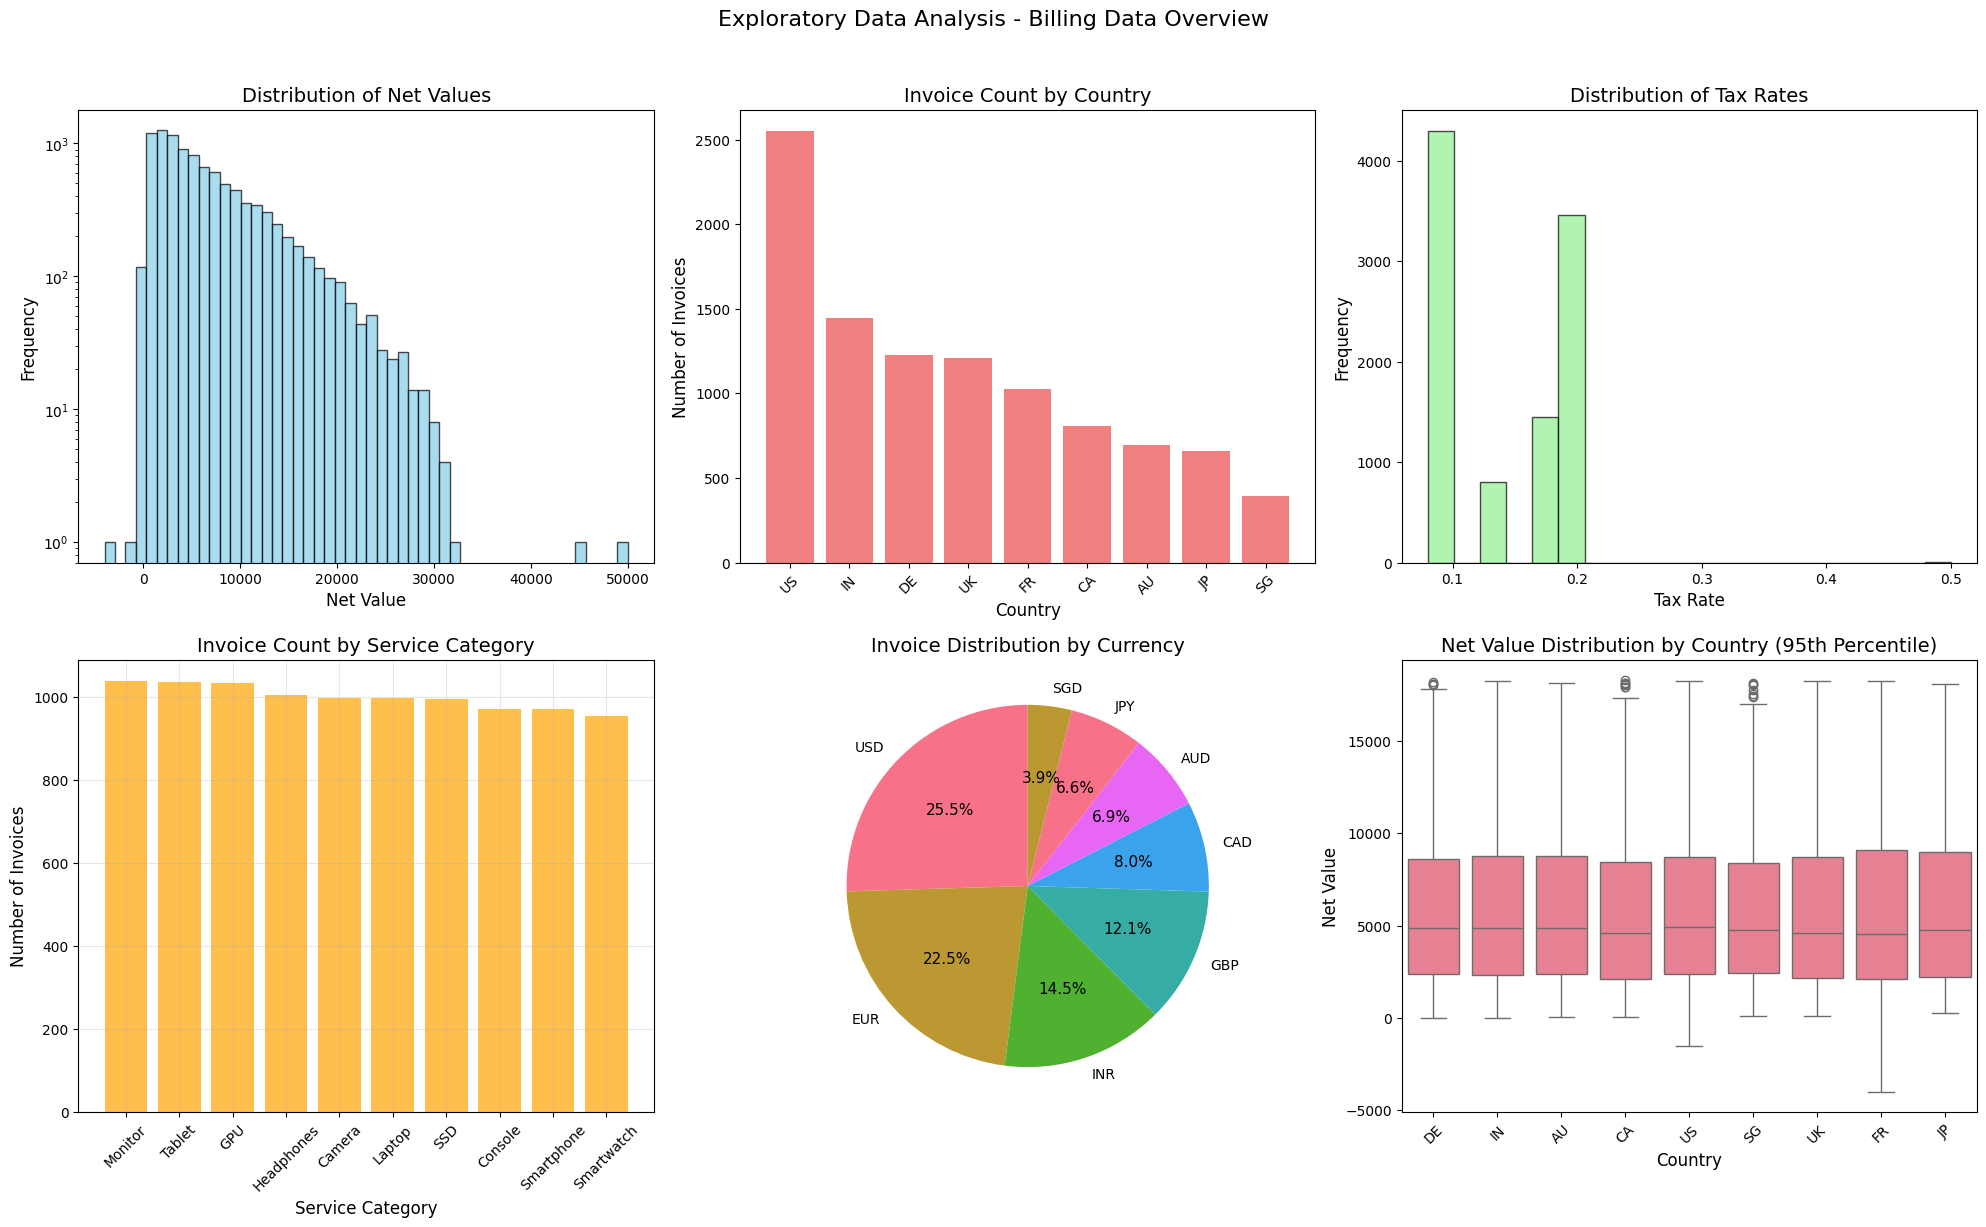

🔍 Key EDA Insights:
📈 Total revenue: $77,149,537.94
📊 Average invoice value: $6,754.38
📏 Value range: $-4,000.00 to $50,000.00
🌍 Countries covered: 9
💱 Currencies: EUR, INR, AUD, CAD, USD, SGD, GBP, JPY
🏢 Unique customers: 8377

Data Quality Check:
   - Zero values: 2
   - Negative values: 2
   - Extreme outliers (>99th percentile): 101
   - Unusual tax rates (>25%): 2


In [4]:
# Create EDA visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Exploratory Data Analysis - Billing Data Overview', fontsize=16, y=1.02)

# 1. Distribution of net values
axes[0, 0].hist(billing_data['net_value'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Net Values')
axes[0, 0].set_xlabel('Net Value')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_yscale('log')  # Log scale due to outliers

# 2. Country distribution
country_counts = billing_data['country'].value_counts()
axes[0, 1].bar(country_counts.index, country_counts.values, color='lightcoral')
axes[0, 1].set_title('Invoice Count by Country')
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Number of Invoices')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Tax rate distribution
axes[0, 2].hist(billing_data['tax_rate'], bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0, 2].set_title('Distribution of Tax Rates')
axes[0, 2].set_xlabel('Tax Rate')
axes[0, 2].set_ylabel('Frequency')

# 4. Service category distribution
service_counts = billing_data['service_category'].value_counts()
axes[1, 0].bar(service_counts.index, service_counts.values, color='orange', alpha=0.7)
axes[1, 0].set_title('Invoice Count by Service Category')
axes[1, 0].set_xlabel('Service Category')
axes[1, 0].set_ylabel('Number of Invoices')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# 5. Currency distribution
currency_counts = billing_data['currency'].value_counts()
axes[1, 1].pie(currency_counts.values, labels=currency_counts.index, autopct='%1.1f%%', startangle=90)
axes[1, 1].set_title('Invoice Distribution by Currency')

# 6. Box plot of net values by country (excluding extreme outliers for visibility)
# Filter out extreme outliers for better visualization
filtered_data = billing_data[billing_data['net_value'] < billing_data['net_value'].quantile(0.95)]
sns.boxplot(data=filtered_data, x='country', y='net_value', ax=axes[1, 2])
axes[1, 2].set_title('Net Value Distribution by Country (95th Percentile)')
axes[1, 2].set_xlabel('Country')
axes[1, 2].set_ylabel('Net Value')
axes[1, 2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print key insights
print("🔍 Key EDA Insights:")
print(f"📈 Total revenue: ${billing_data['total_amount'].sum():,.2f}")
print(f"📊 Average invoice value: ${billing_data['net_value'].mean():,.2f}")
print(f"📏 Value range: ${billing_data['net_value'].min():,.2f} to ${billing_data['net_value'].max():,.2f}")
print(f"🌍 Countries covered: {billing_data['country'].nunique()}")
print(f"💱 Currencies: {', '.join(billing_data['currency'].unique())}")
print(f"🏢 Unique customers: {billing_data['customer_id'].nunique()}")

# Check for obvious data quality issues
print(f"\nData Quality Check:")
print(f"   - Zero values: {(billing_data['net_value'] == 0).sum()}")
print(f"   - Negative values: {(billing_data['net_value'] < 0).sum()}")
print(f"   - Extreme outliers (>99th percentile): {(billing_data['net_value'] > billing_data['net_value'].quantile(0.99)).sum()}")
print(f"   - Unusual tax rates (>25%): {(billing_data['tax_rate'] > 0.25).sum()}")

#### 📊 **EDA Key Findings**

From our exploratory analysis, we can see:

- **Value Distribution**: Most invoices are in the $1K-$10K range, with some extreme outliers (>$1M)
- **Geographic Spread**: Multi-country dataset with US, UK, Germany, France, Canada, Australia, Japan, Singapore, and India
- **Tax Rates**: Standard country-specific rates (7%-20%), with some suspicious 0% and >25% rates flagged
- **Currency Diversity**: Multi-currency transactions (USD, EUR, GBP, CAD, AUD, JPY, SGD, INR) matching geographic distribution
- **Service Categories**: Multiple business services represented across different industries
- **Data Quality Issues**: Successfully identified various anomalies requiring ML detection:
   - Zero/negative values in critical fields
   - Tax calculation inconsistencies
   - Extreme statistical outliers
   - Unusual tax rates outside normal ranges

**Key Statistics:**
- Total revenue: $77.1M+ across 10,010 transactions
- Average invoice value varies significantly in
- Multiple currencies and tax jurisdictions increase complexity